# Imports

In [1]:
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from numpy.linalg import inv
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import seaborn as sns
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

sns.set()

%config InlineBackend.figure_format = 'retina'

In this task we are gonna to implement simple Linear Regression which works with the matrices and compute optimal weights for the model. Let's start from scratch and write class NormalLR that building optimal weights for model relying on mathematic prooves we got on lectures. Firstly, we need to store shapes for the result matrices. Also for the sake of multiplying large matrices I will separate inverted and other matrices.

$$\mathbf{y}=\mathbf{X} \mathbf{w}+\varepsilon,$$
where
- $\mathbf{w} \in \mathbb{R}^{m+1}-$ is a $(m+1) \times 1$ column-vector of the model parameters (in machine learning, these parameters are often referred to as weights);
- $\mathbf{X} \in \mathbb{R}^{n \times(m+1)}-$ is a $n \times(m+1)$ matrix of observations and their features, (including the fictitious column on the left) with full column rank): $\operatorname{rank}(\mathbf{X})=m+1$
- $\epsilon \in \mathbb{R}^{n}-$ is a $n \times 1$ random column-vector, referred to as error or noise;
- $\mathbf{y} \in \mathbb{R}^{n}-$ is a $n \times 1$ column-vector - the dependent (or target) variable.

So, our optimal weights after finding minimum are:
$\mathbf{w}^{*}=\left(\mathbf{X}^{\mathrm{T}} \mathbf{X}\right)^{-1} \mathbf{X}^{\mathrm{T}} \mathbf{y}$

In [2]:
class NormalLR:
    def __init__(self, reg_coef=0):
        self.W = None
        self.C = reg_coef
        self.n_rows = None
        self.n_cols = None
        self.model_fitted = False

    
    def fit(self, X, y):
        self.n_rows, self.n_cols = X.shape[0], X.shape[1]
        Z = X.T @ X + self.C * np.identity(self.n_cols)
        self.W = inv(Z) @ X.T @ y
        self.model_fitted = True

    
    def predict(self, X):
        if self.model_fitted:
            y_pred = np.dot(X, self.W)
            return y_pred
        else:
            print("It looks like you haven't fit your Awesome LR model. Use .fit method.")



Also, we need to defined `RMSE` metric.

In [3]:
def RMSE(y_true, y_pred):
    res_vector = (y_true - y_pred) ** 2
    return np.sqrt(np.mean(res_vector))

Let's generate test data and check out how implemented LinReg works

In [4]:
def generate_synthetic(size, dim=6, noise=0.1):
    X = np.random.randn(size, dim)
    w = np.random.randn(dim + 1)
    noise = noise * np.random.randn(size)
    y = X.dot(w[1:]) + w[0] + noise
    return X, y

X, y = generate_synthetic(1024)   

Splitting data for validating

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

In [6]:
regr1 = NormalLR()
regr1.fit(X_train, y_train)
print(RMSE(y_test, regr1.predict(X_test)))

0.13003666310872591


# Testing real-world data

First thing first we would like to see the data and prepare it for the model. I think we need following steps:
- Remove correlated features. It always overfits LinReg model because of the large numbers in matrix
- Remove noise and outliers. Of course data has some outliers, and it will be crucial for our model to see good data
- Scaling is always good. We want to get to N(0, 1) as close as possible 

Reading data is always ugly while it in-cell. We would like to keep notebook clean so let's write simple function

In [7]:
def read_data(path):
    X = pd.read_csv(path + 'x_boston_train.csv').drop('Id', axis=1)
    y = pd.read_csv(path + 'y_boston_train.csv').drop('Id', axis=1).rename(columns={'Expected': 'y'})
    return X, y['y']

In [8]:
X, y = read_data('data/')

## Correlation

<AxesSubplot:>

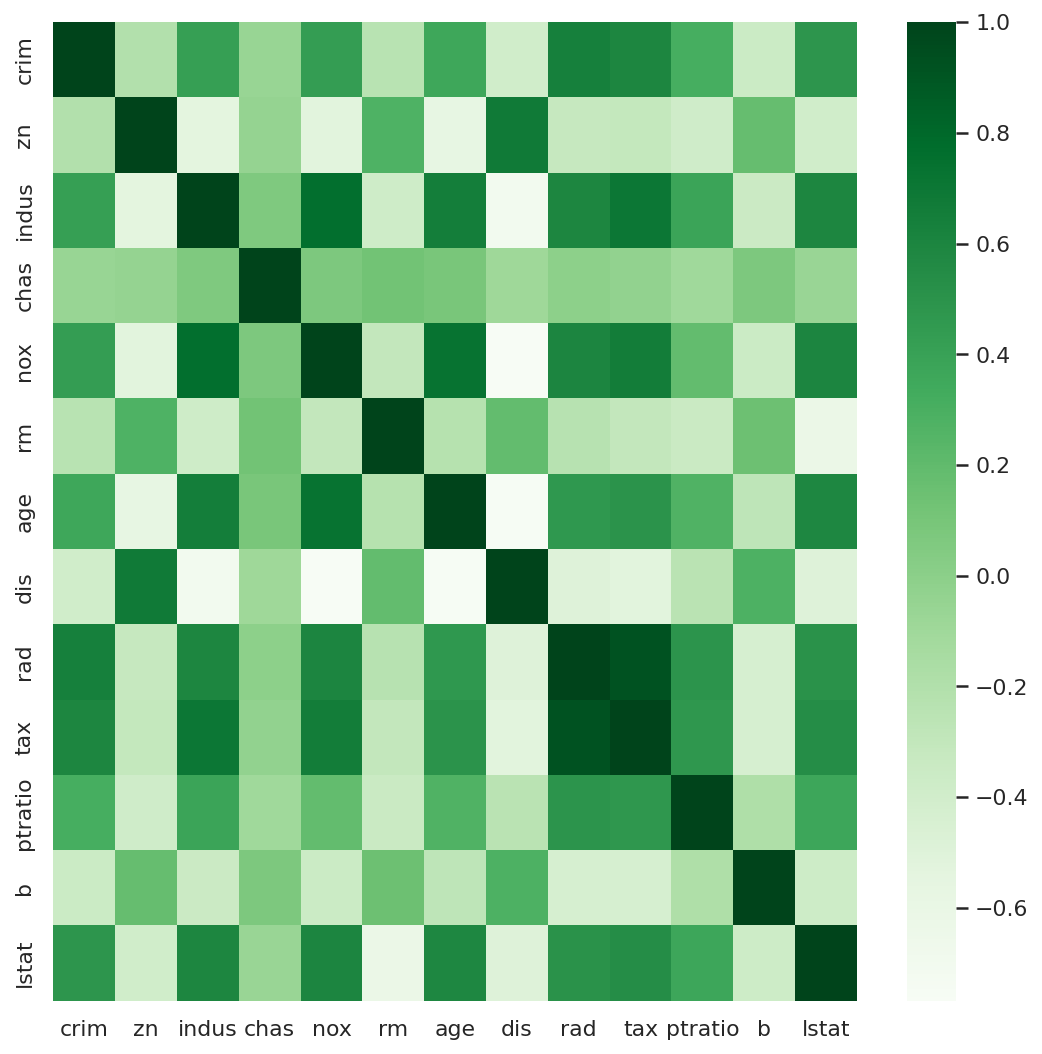

In [9]:
plt.figure(figsize=(9, 9))
sns.heatmap(X.corr(), cmap="Greens")

nox - tax;
tax - rad;
nox - indus;
indus - age;
indus - tax;
dis - zn;
dis - age;

These are the high-correlated features from out dataset. I think we have enough data to feed our model without some of them. Indeed, in more sophisticated analysis I would compute VIF's for each feature and maybe combine some of them, but we are here to implement LR and test it on somewhat ok data.


## Scaling and dealing with outliers

### Crime

In [10]:
pd.concat([X, y], axis=1).describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
crim,404.0,3.78,8.70,0.01,0.08,0.25,3.84,88.98
zn,404.0,11.27,23.06,0.00,0.00,0.00,12.50,95.00
indus,404.0,11.24,6.87,0.46,5.18,9.69,18.10,27.74
chas,404.0,0.06,0.24,0.00,0.00,0.00,0.00,1.00
nox,404.0,0.56,0.12,0.38,0.45,0.54,0.62,0.87
rm,404.0,6.29,0.73,3.56,5.89,6.21,6.63,8.78
age,404.0,68.87,28.02,2.90,45.32,77.70,94.02,100.00
dis,404.0,3.73,2.08,1.14,2.08,3.14,5.12,12.13
rad,404.0,9.74,8.79,1.00,4.00,5.00,24.00,24.00
tax,404.0,410.88,169.45,187.00,279.00,336.00,666.00,711.00


<Figure size 720x720 with 0 Axes>

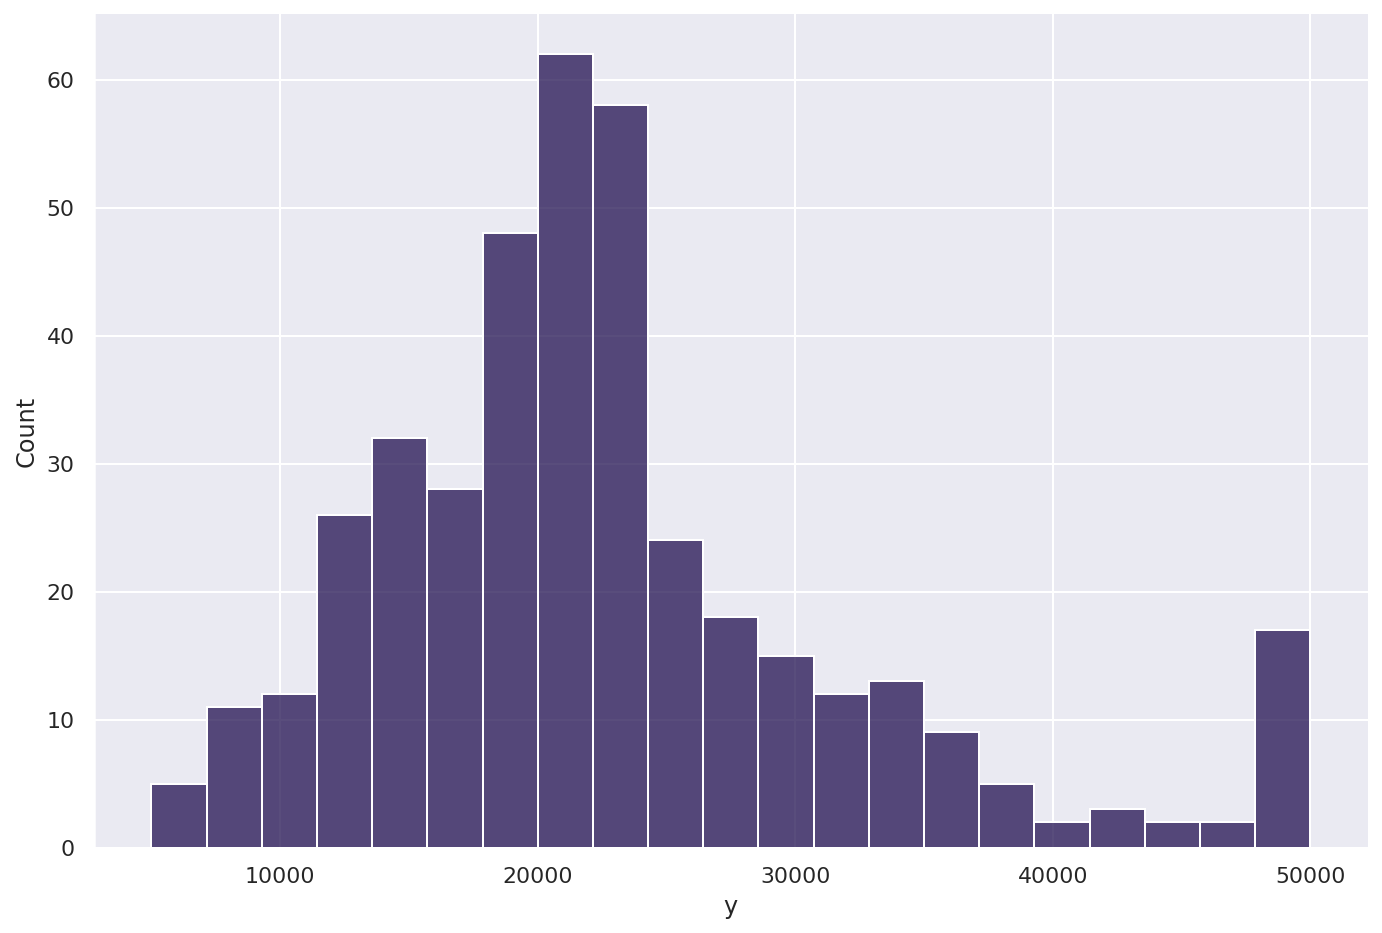

In [11]:
sns.set_palette(sns.color_palette("magma"))

plt.figure(figsize=(10,10))
g = sns.displot(data=y,log_scale=0)
g.fig.set_figwidth(11)
g.fig.set_figheight(7)

## Process Data

## Transform some numeric features into categorical and then One-Hot
Do not forget to drop one column to avoid multiple correlation!

### Crimes feature

<Figure size 720x720 with 0 Axes>

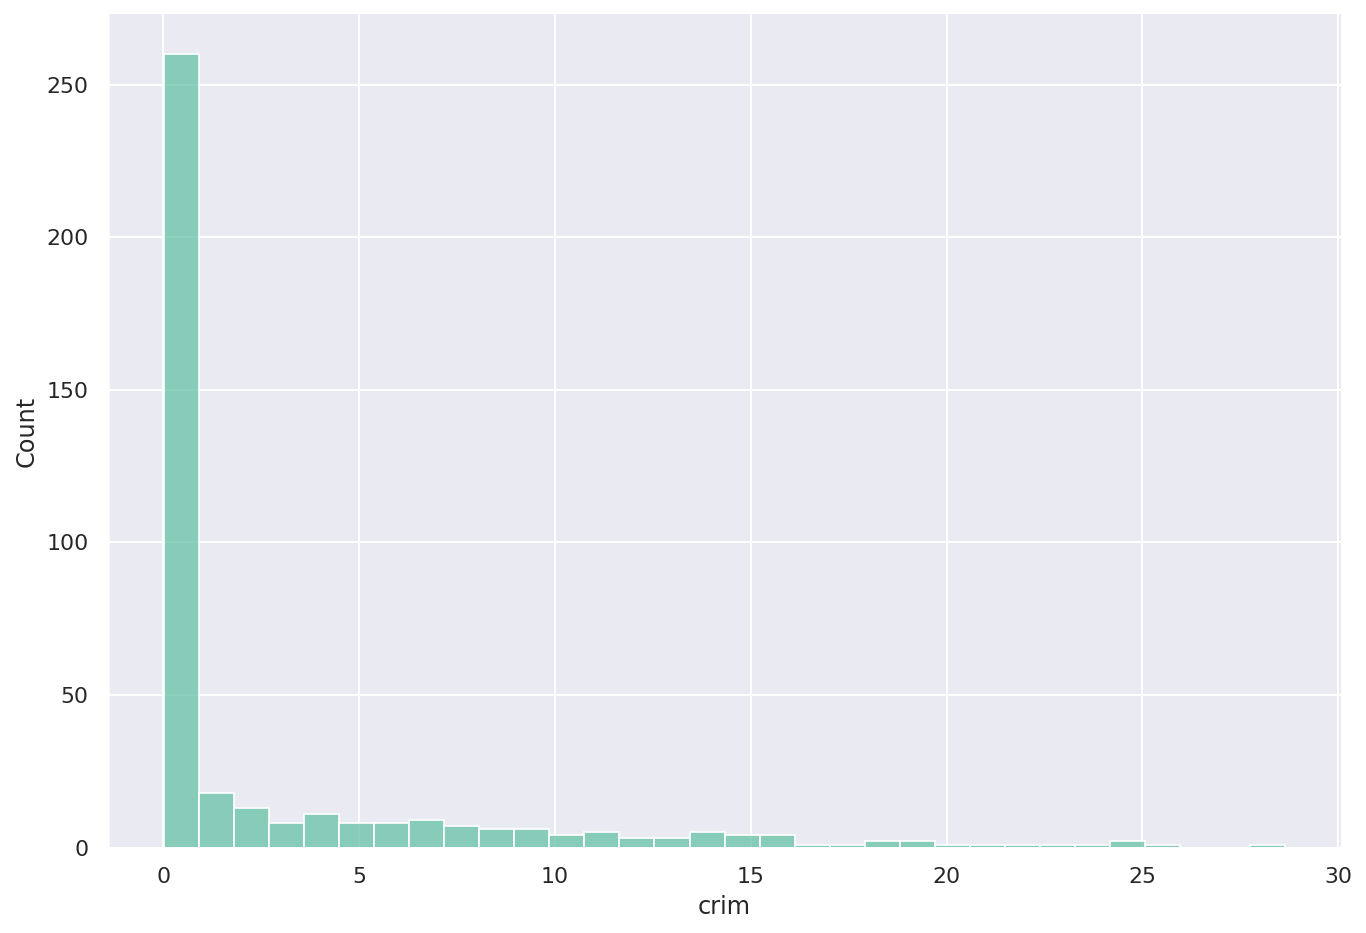

In [12]:
sns.set_palette(sns.color_palette("Set2"))

plt.figure(figsize=(10,10))
g = sns.displot(data=X.loc[X['crim'] < 30], x='crim',log_scale=0)
g.fig.set_figwidth(11)
g.fig.set_figheight(7)

Looks like our data could be transformed into bins, then we can make it categorical. Categorical -> numeric.

In [13]:
crim_dict = {}
X['crim'] = np.floor(X['crim'])

for v in X['crim'].unique():
    if v > 2:
        crim_dict[v] = 1
    else:
        crim_dict[v] = 0

X['crim'] = X['crim'].map(crim_dict)

### Rad

<Figure size 720x720 with 0 Axes>

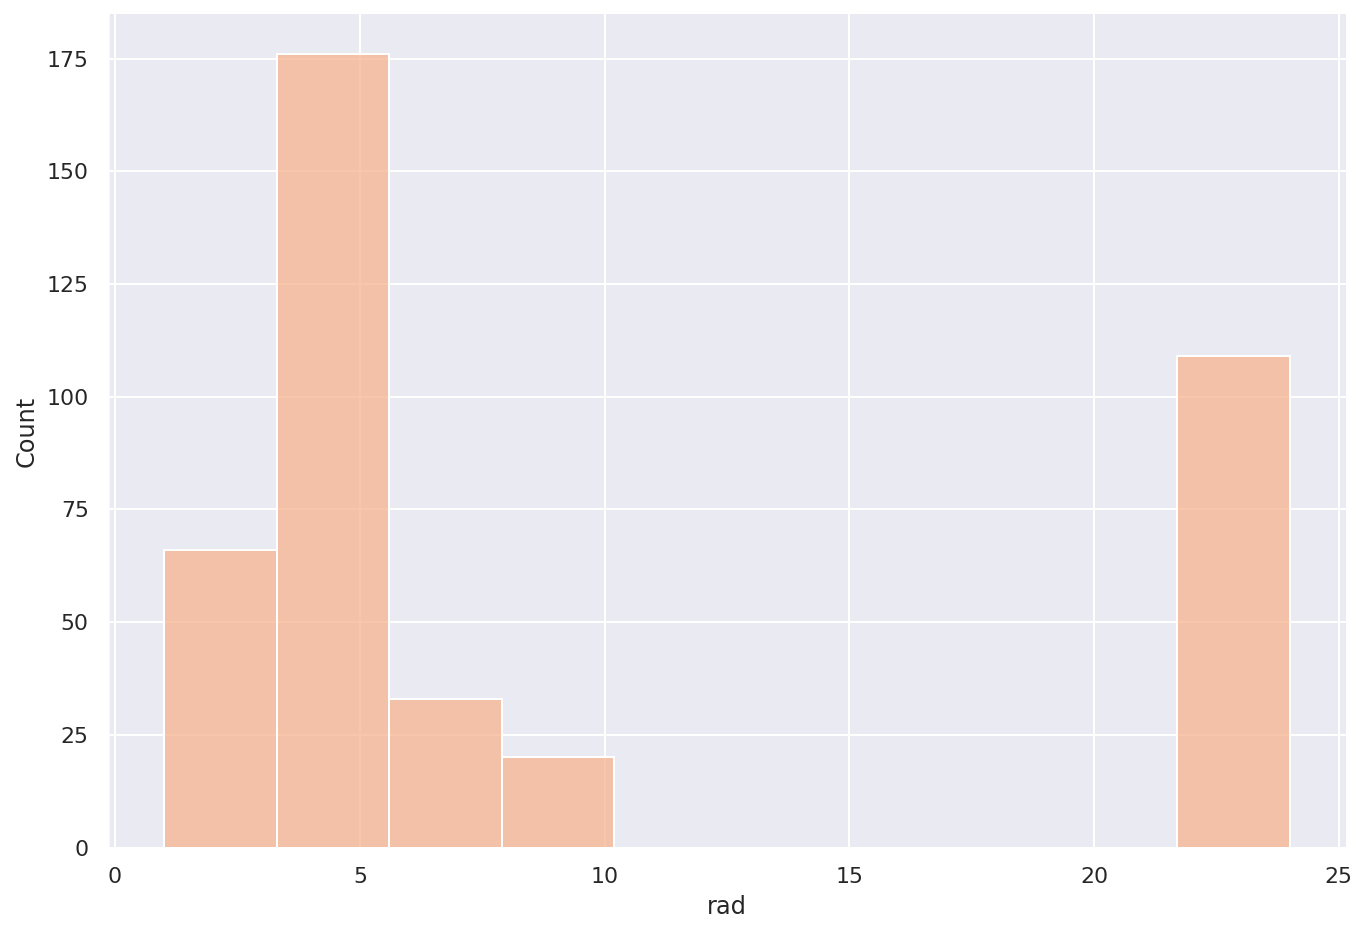

In [14]:
sns.set_palette(sns.color_palette("rocket_r"))

plt.figure(figsize=(10,10))
g = sns.displot(data=X, x='rad',log_scale=0)
g.fig.set_figwidth(11)
g.fig.set_figheight(7)

In [15]:
X = pd.concat([X, pd.get_dummies(X['rad'], prefix='rad', drop_first=True)], axis=1)

### Rooms

Rooms is the key factor for the price of the house. So I think it is wise to round the floar value and one-hot encode them. At least, on validation it gave me nice score.

In [16]:
X['rm'] = np.round(X['rm']).astype('int')

X = pd.concat([X, pd.get_dummies(X['rm'], prefix='rm', drop_first=True)], axis=1)

### Zn

In [17]:
zn_dict = {}
X['zn'] = np.floor(X['zn'])

for v in X['zn'].unique():
    if v > 0:
        zn_dict[v] = 0
    else:
        zn_dict[v] = 1

X['zn'] = X['zn'].map(zn_dict)

### Generating degrees of regressors

In [18]:
feats_for_degree = ['b', 'lstat', 'dis']

for col in feats_for_degree:
    power2 = 2
    X[col + '^' + str(power2)] = X[col] **2
    power3 = 3
    X[col + '^' + str(power3)] = X[col] **3 

## Cut values and split

In [19]:
def process_data(X, y, rem_feats, cut_vals, seed):
    df = pd.concat([X, y], axis=1)
    if len(cut_vals):
        for col in cut_vals:
            df = df.loc[df[col] < cut_vals[col]]

    X = df.drop('y', axis=1)
    y = df['y']
    if len(rem_feats):
        X.drop(rem_feats, axis=1, inplace=True)
    

    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=False, random_state=seed)
    
    return X_train, X_test, y_train, y_test

As we can see on the graph above, we have some houses that costs like 50.000, so we can skip them and validate without them to see more stable results. But for the final fit we will incliude them.

In [20]:
l = ['rm', 'rad', 'rm_5', 'rm_9']
# , 'crim', 'rm_8', 'rm_7', 'rm_6', 'rad_8']
X_train, X_test, y_train, y_test = process_data(X, y, l, {'y': 40000}, seed=92)

<AxesSubplot:>

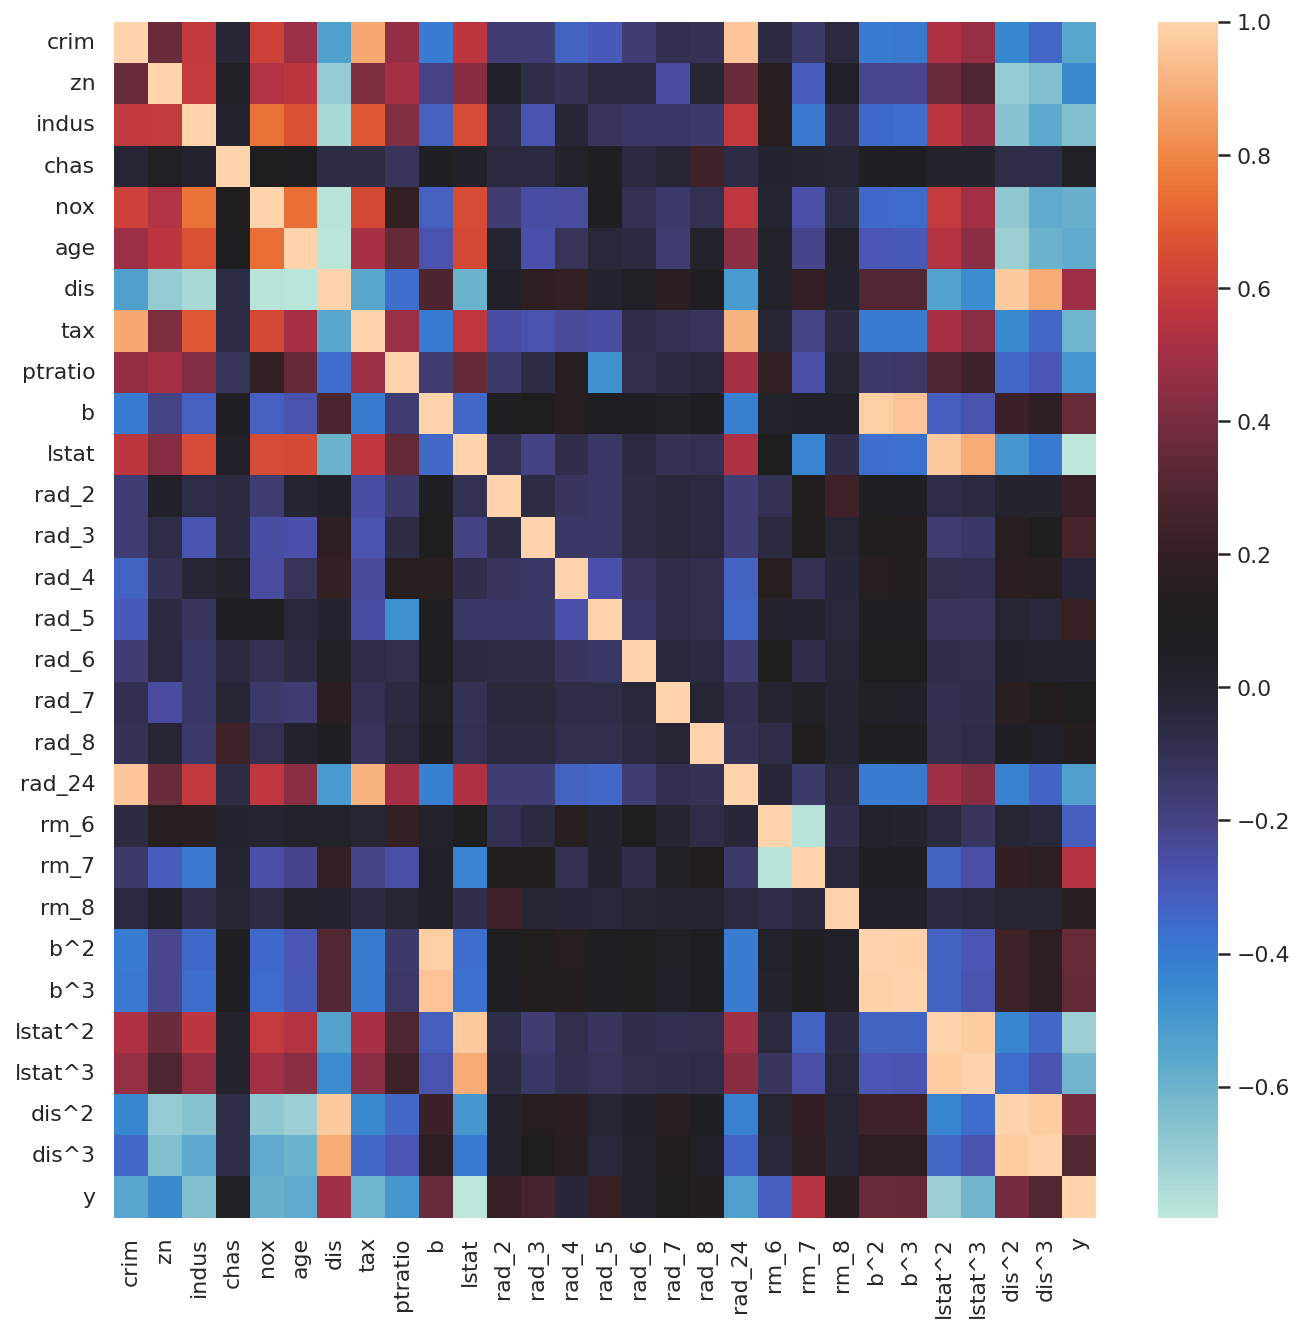

In [21]:
plt.figure(figsize=(11, 11))
sns.heatmap(pd.concat([X_train, y_train], axis=1).corr(), cmap="icefire")

## Fitting simple LR

In [22]:
simple_reg = NormalLR()
simple_reg.fit(X_train, y_train)

# validate results
res = RMSE(y_test, simple_reg.predict(X_test))
print(f'RMSE score for the default LinReg is: {res:.2f}')

RMSE score for the default LinReg is: 3832.56


## Testing regularization

Let's define some regularization coefficients and distinguish what is the best hyper-parameter for LR. We can build nice plot for this.

In [23]:
%%time
rmse_arr = []
coef_ref_arr = [(0.17 + i/100) for i in range(100)]

for c in coef_ref_arr:
    reg = NormalLR(reg_coef=c)
    reg.fit(X_train, y_train)
    curr_res = RMSE(y_test, reg.predict(X_test))
    rmse_arr.append(curr_res)
 

CPU times: user 1.21 s, sys: 1.11 s, total: 2.32 s
Wall time: 634 ms


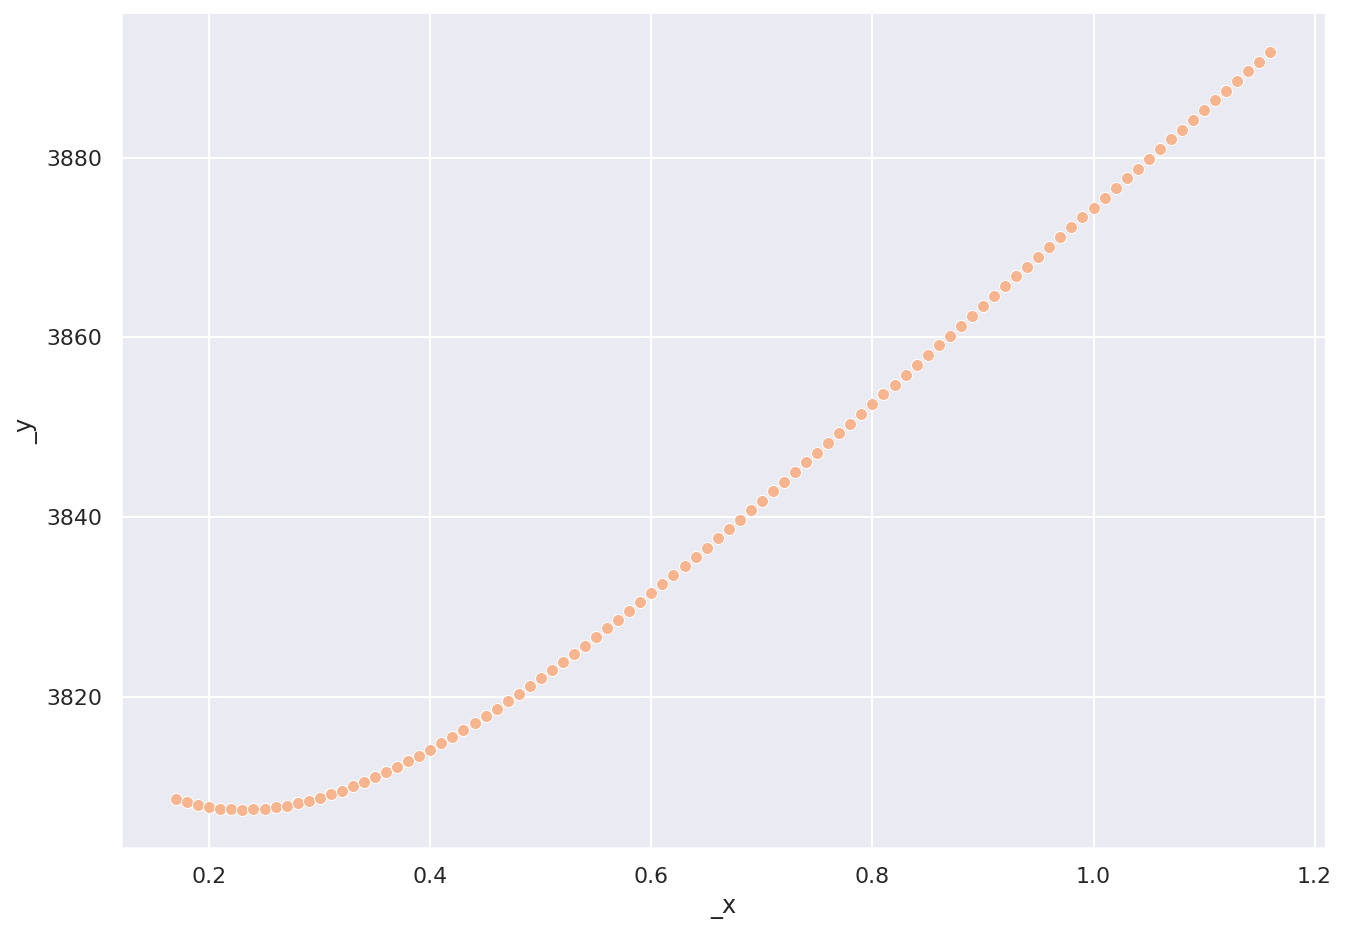

<Figure size 720x720 with 0 Axes>

In [24]:
g = sns.relplot(x=coef_ref_arr, y=rmse_arr)

plt.figure(figsize=(10,10))
g.fig.set_figwidth(11)
g.fig.set_figheight(7)

In [25]:
print(f'Best score on validation is: {min(rmse_arr)}')
print(f'Best regularization coef is: {coef_ref_arr[rmse_arr.index(min(rmse_arr))]}')

Best score on validation is: 3807.4776600200858
Best regularization coef is: 0.23


## Best Model Evaluating

In [26]:
mask = y < 4 * (10 ** 7)

best_reg_model = NormalLR(reg_coef=0.23)

We found the best paramet, so now we can fit final model for the submission.

In [27]:
%%time
best_reg_model.fit(X.loc[mask].drop(['rad', 'rm', 'rm_9', 'rm_5'], axis=1), y[mask])

CPU times: user 14.4 ms, sys: 14.8 ms, total: 29.2 ms
Wall time: 11.6 ms


Matrices multiplication is so fast!

# Submit on Kaggle

Process test data

In [28]:
def feat_engineering(X):
    # crim
    crim_dict = {}
    X['crim'] = np.floor(X['crim'])

    for v in X['crim'].unique():
        if v > 2:
            crim_dict[v] = 1
        else:
            crim_dict[v] = 0

    X['crim'] = X['crim'].map(crim_dict)

    # rad
    X = pd.concat([X, pd.get_dummies(X['rad'], prefix='rad', drop_first=True)], axis=1)

    # rooms
    # X['rm'] = np.ceil(X['rm'] * 2 - 6).astype('int')
    X['rm'] = np.round(X['rm']).astype('int')

    X = pd.concat([X, pd.get_dummies(X['rm'], prefix='rm', drop_first=True)], axis=1)

    # Zn
    zn_dict = {}
    X['zn'] = np.floor(X['zn'])

    for v in X['zn'].unique():
        if v > 0:
            zn_dict[v] = 0
        else:
            zn_dict[v] = 1

    X['zn'] = X['zn'].map(zn_dict)

    # powers
    feats_for_degree = ['b', 'lstat', 'dis']

    for col in feats_for_degree:
        power2 = 2
        X[col + '^' + str(power2)] = X[col] **2
        power3 = 3
        X[col + '^' + str(power3)] = X[col] **3 

    return X
